In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import gc

from datetime import datetime

sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)  

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# To force some binary varibles to be read as str
dtypes = \
{
    'projectid': str,
    'teacher_acctid': str,                                                                              
    'school_metro': str,                                          
    'school_charter': str,                                
    'teacher_prefix': str,                                        
    'teacher_teach_for_america': str,                                                                                             
    'eligible_double_your_impact_match': str,                      
    'eligible_almost_home_match': str,                                                                                                                                                      
}

In [3]:
df = pd.read_csv('../Data/Kaggle/KDDCup14/feature_selection.csv', dtype=dtypes)

In [4]:
categorical = list(df.select_dtypes(include=[object]).columns)

In [5]:
categorical

['projectid',
 'teacher_acctid',
 'school_metro',
 'school_charter',
 'teacher_prefix',
 'teacher_teach_for_america',
 'primary_focus_subject',
 'resource_type',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'date_posted',
 'short_description']

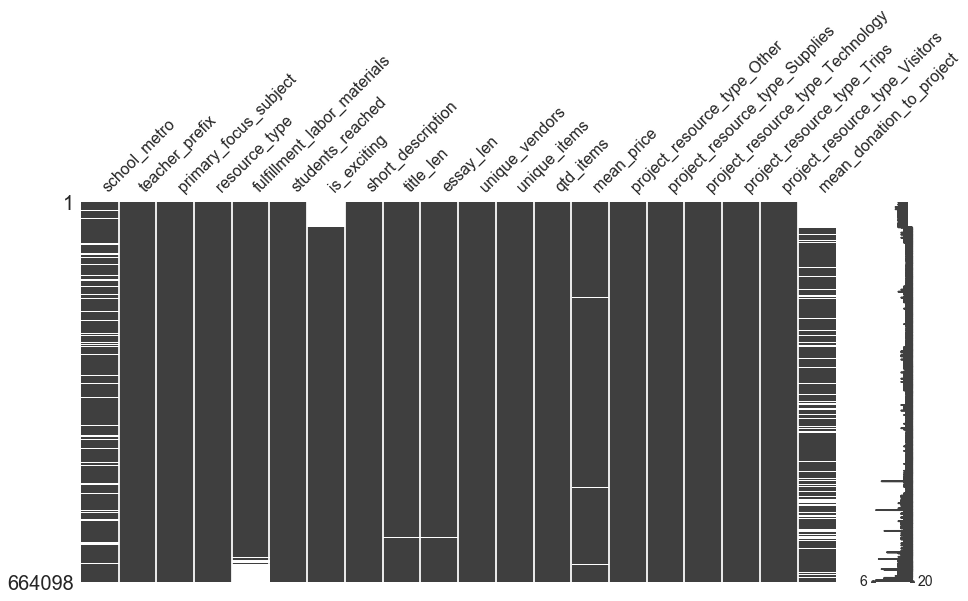

In [6]:
missing_columns = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missing_columns], figsize=(15, 7))

In [7]:
from sklearn.preprocessing import LabelEncoder

categorical = list(df.select_dtypes(include=[object]).columns)
exclude = ['projectid', 'teacher_acctid', 'short_description', 'date_posted']

to_consider = [cat for cat in categorical if not cat in exclude]

le = LabelEncoder()
for cat in to_consider:
        print(cat)
        df[cat] = le.fit_transform(df[cat].astype(str))
        print(le.classes_)
        print(le.transform(le.classes_))

school_metro
['nan' 'rural' 'suburban' 'urban']
[0 1 2 3]
school_charter
['0' '1']
[0 1]
teacher_prefix
['Dr.' 'Mr.' 'Mr. & Mrs.' 'Mrs.' 'Ms.' 'nan']
[0 1 2 3 4 5]
teacher_teach_for_america
['0' '1']
[0 1]
primary_focus_subject
['Applied Sciences' 'Character Education' 'Civics & Government'
 'College & Career Prep' 'Community Service' 'ESL' 'Early Development'
 'Economics' 'Environmental Science' 'Extracurricular' 'Foreign Languages'
 'Gym & Fitness' 'Health & Life Science' 'Health & Wellness'
 'History & Geography' 'Literacy' 'Literature & Writing' 'Mathematics'
 'Music' 'Nutrition' 'Other' 'Parent Involvement' 'Performing Arts'
 'Social Sciences' 'Special Needs' 'Sports' 'Visual Arts' 'nan']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
resource_type
['Books' 'Other' 'Supplies' 'Technology' 'Trips' 'Visitors' 'nan']
[0 1 2 3 4 5 6]
eligible_double_your_impact_match
['0' '1']
[0 1]
eligible_almost_home_match
['0' '1']
[0 1]


In [8]:
for c in categorical:
    df[c] = df[c].astype('category')

In [9]:
numerical = list(df.select_dtypes(include=[np.number]).drop('is_exciting', axis=1).columns)
df.loc[:, numerical].fillna(0, inplace=True)

In [10]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df_train = df[(df['date_posted'].dt.year > 2009) & (df['date_posted'].dt.year < 2014)].copy()
df_test = df[df['date_posted'].dt.year >= 2014].copy()

In [11]:
df_train.shape

(439599, 55)

In [12]:
df_test.shape

(44772, 55)

In [13]:
del df
gc.collect()

5238

### Modeling

In [14]:
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [15]:
df_ids = df_test['projectid'].copy()

In [16]:
df_train.drop(['date_posted', 'projectid', 'teacher_acctid'], axis=1, inplace=True)
df_test.drop(['date_posted', 'projectid', 'teacher_acctid'], axis=1, inplace=True)

#### Baseline

In [17]:
X = df_train.drop(['short_description', 'is_exciting'], axis=1).copy()
y = df_train['is_exciting']

In [18]:
X_ = df_test.drop(['short_description', 'is_exciting'], axis=1).copy()

In [19]:
import lightgbm as lgbm

In [20]:
X.shape

(439599, 50)

In [21]:
y.shape

(439599,)

In [22]:
from sklearn.model_selection import KFold

clf_lgbm = lgbm.LGBMClassifier(is_unbalance=True, random_state=0, n_jobs=-1)
kfold = KFold(n_splits=10, random_state=0)
results = cross_val_score(clf_lgbm, X, y, cv=kfold)

print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 78.331% (2.284%)


In [23]:
clf_lgbm.fit(X, y)
y_ = clf_lgbm.predict_proba(X_)

In [24]:
y_.max()

0.99996437367889357

In [25]:
y_[:, 1].max()

0.0041888254554370077

In [26]:
df = pd.DataFrame({'projectid': df_ids, 'is_exciting': y_[:, 1].flatten()})

In [27]:
df.head()

,is_exciting,projectid
0,0.000117,316ed8fb3b81402ff6ac8f721bb31192
1,0.000224,90de744e368a7e4883223ca49318ae30
2,0.000137,32943bb1063267de6ed19fc0ceb4b9a7
3,0.000326,bb18f409abda2f264d5acda8cab577a9
4,0.000420,24761b686e18e5eace634607acbcc19f


In [28]:
df.to_csv('../Data/Kaggle/KDDCup14/submission.csv', index=False)

Score: 0.50553

#### Hyperparameter Tunning

In [29]:
clf_lgbm = lgbm.LGBMClassifier(is_unbalance=True, random_state=0)
model_params = {
    'learning_rate':        [0.03, 0.05, 0.08],
    'num_leaves':           [31, 70, 150],
    'min_data_in_leaf':     [5, 7, 10],
    'max_depth':            [-1, 5, 7, 10],
    'subsample':            [0.7, 0.9, 1.0],
    'subsample_freq':       [1, 3, 5],
    'min_data_in_bin':      [2, 3, 5],
    'colsample_bytree':     [0.3, 0.6, 0.9]
}

grid = RandomizedSearchCV(clf_lgbm, model_params, cv=5, verbose=1, scoring='roc_auc', \
                          n_jobs=-1, n_iter=200, random_state=0)
grid.fit(X, y)

print (grid.best_params_)
print (grid.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 99.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 126.7min finished


{'subsample_freq': 1, 'subsample': 0.9, 'num_leaves': 31, 'min_data_in_leaf': 5, 'min_data_in_bin': 3, 'max_depth': 10, 'learning_rate': 0.08, 'colsample_bytree': 0.9}
0.902195316726


In [31]:
y_ = grid.best_estimator_.predict_proba(X_)

In [32]:
y_.max()

0.99980851287012973

In [33]:
y_[:, 1].max()

0.0039929872724737553

In [34]:
df = pd.DataFrame({'projectid': df_ids, 'is_exciting': y_[:, 1].flatten()})

In [35]:
df.head()

,is_exciting,projectid
0,0.000371,316ed8fb3b81402ff6ac8f721bb31192
1,0.000631,90de744e368a7e4883223ca49318ae30
2,0.000334,32943bb1063267de6ed19fc0ceb4b9a7
3,0.001011,bb18f409abda2f264d5acda8cab577a9
4,0.001367,24761b686e18e5eace634607acbcc19f


In [36]:
df.to_csv('../Data/Kaggle/KDDCup14/submission.csv', index=False)

Score: 0.50578